In [9]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()
BUCKET = sess.default_bucket()
PREFIX = 'input'
labeling_job_name = 'bees-500'

arn:aws:iam::576262453777:role/service-role/AmazonSageMaker-ExecutionRole-20210210T010860
CPU times: user 514 ms, sys: 41.8 ms, total: 556 ms
Wall time: 912 ms


## Download Dataset

In [96]:
!wget http://aws-tc-largeobjects.s3-us-west-2.amazonaws.com/DIG-TF-200-MLBEES-10-EN/dataset.zip 
!unzip -qo dataset.zip

--2021-02-10 10:32:44--  http://aws-tc-largeobjects.s3-us-west-2.amazonaws.com/DIG-TF-200-MLBEES-10-EN/dataset.zip
Resolving aws-tc-largeobjects.s3-us-west-2.amazonaws.com (aws-tc-largeobjects.s3-us-west-2.amazonaws.com)... 52.218.234.145
Connecting to aws-tc-largeobjects.s3-us-west-2.amazonaws.com (aws-tc-largeobjects.s3-us-west-2.amazonaws.com)|52.218.234.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70375947 (67M) [application/x-zip-compressed]
Saving to: ‘dataset.zip.3’

dataset.zip.3       100%[===================>]  67.12M  6.44MB/s    in 11s     

2021-02-10 10:32:56 (5.91 MB/s) - ‘dataset.zip.3’ saved [70375947/70375947]



In [97]:
!unzip -l dataset.zip | tail -20

   251027  05-15-2019 19:21   9530124.jpg
   110561  05-15-2019 19:21   9542264.jpg
   312354  05-15-2019 19:21   9543188.jpg
    76903  05-15-2019 19:21   9637165.jpg
    48663  05-15-2019 19:21   9765741.jpg
    66393  05-15-2019 19:21   9787032.jpg
   273392  05-22-2019 21:58   output.manifest
        0  06-01-2019 05:51   test/
    83438  06-01-2019 05:51   test/22427594.jpg
   152133  06-01-2019 05:51   test/22469656.jpg
   205930  06-01-2019 05:51   test/22544384.jpg
   137755  06-01-2019 05:51   test/22673445.jpg
   124565  06-01-2019 05:51   test/22741822.jpg
    39502  06-01-2019 05:51   test/22774999.jpg
    39086  06-01-2019 05:51   test/22775000.jpg
   149389  06-01-2019 05:51   test/22901964.jpg
   103322  06-01-2019 05:51   test/22971237.jpg
   109178  06-01-2019 05:51   test/23086755.jpg
---------                     -------
 70635014                     512 files


#### uploading data to S3 Bucket

In [81]:
!aws s3 sync --exclude="*" --include="[0-9]*.jpg" . s3://$BUCKET/$PREFIX/

In [98]:
#replacing bucket name and prefix to right format
outputManifest = open("output.manifest", "rt")
#read file contents to string
manifest = outputManifest.read()
#replace all occurrences of the required string
replaceStr = '//'+BUCKET+'/'+PREFIX
manifest = manifest.replace('//sagemaker-remars/datasets/na-bees/500', replaceStr)
#close the input file
outputManifest.close()
#open the input file in write mode
outputManifest = open("output.manifest", "wt")
#overrite the input file with the resulting data
outputManifest.write(manifest)
#close the file
outputManifest.close()

In [99]:
print(BUCKET)

sagemaker-us-east-1-576262453777


In [100]:
!head -4 './output.manifest'

{"source-ref":"s3://sagemaker-us-east-1-576262453777/input/10006450.jpg","bees-500":{"annotations":[{"class_id":0,"width":95.39999999999998,"top":256.2,"height":86.80000000000001,"left":177}],"image_size":[{"width":500,"depth":3,"height":500}]},"bees-500-metadata":{"job-name":"labeling-job/bees-500","class-map":{"0":"bee"},"human-annotated":"yes","objects":[{"confidence":0.75}],"creation-date":"2019-05-16T00:15:58.914553","type":"groundtruth/object-detection"}}
{"source-ref":"s3://sagemaker-us-east-1-576262453777/input/10022723.jpg","bees-500":{"annotations":[{"class_id":0,"width":93.8,"top":228.8,"height":135,"left":126.8}],"image_size":[{"width":375,"depth":3,"height":500}]},"bees-500-metadata":{"job-name":"labeling-job/bees-500","class-map":{"0":"bee"},"human-annotated":"yes","objects":[{"confidence":0.82}],"creation-date":"2019-05-16T00:41:33.384412","type":"groundtruth/object-detection"}}
{"source-ref":"s3://sagemaker-us-east-1-576262453777/input/10059108.jpg","bees-500":{"annotat

In [11]:
import os
import boto3
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from itertools import cycle

def show_annotated_image(img_path, bboxes):
    im = np.array(Image.open(img_path), dtype=np.uint8)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    colors = cycle(['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w'])
    
    for bbox in bboxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((bbox['left'],bbox['top']),bbox['width'],bbox['height'],linewidth=1,edgecolor=next(colors),facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

##### Plotting Output of the Ground Truth

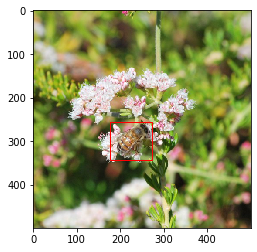

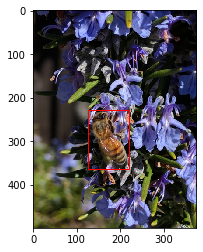

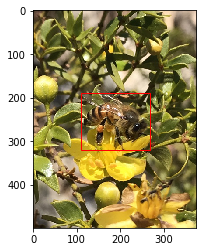

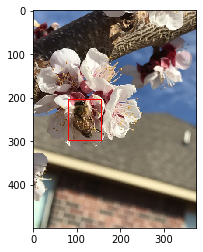

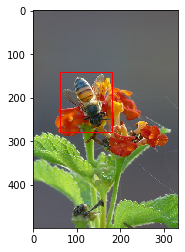

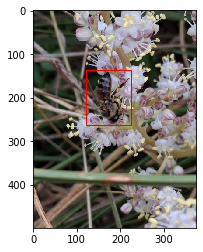

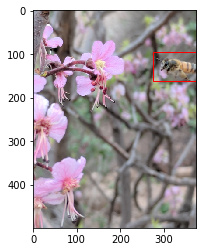

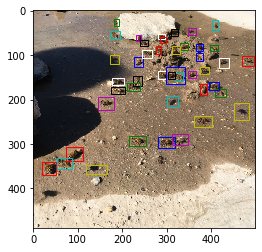

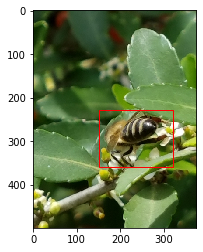

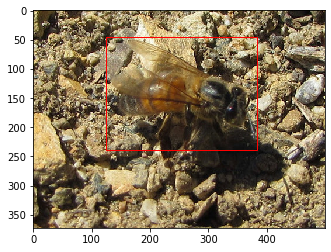

In [12]:
!pip -q install --upgrade pip
!pip -q install jsonlines
import jsonlines
from itertools import islice
import os

with jsonlines.open('./output.manifest', 'r') as reader:
    for desc in islice(reader, 10):
        img_url = desc['source-ref']
        img_file = os.path.basename(img_url)
        file_exists = os.path.isfile(img_file)

        bboxes = desc[labeling_job_name]['annotations']
        show_annotated_image(img_file, bboxes)

#### splitting Manifest to Training and Validation

In [103]:
import json

with jsonlines.open('./output.manifest', 'r') as reader:
    lines = list(reader)
    # Shuffle data in place.
    np.random.shuffle(lines)
    
dataset_size = len(lines)
num_training_samples = int(round(dataset_size*0.8))

train_data = lines[:num_training_samples]
validation_data = lines[num_training_samples:]

augmented_manifest_filename_train = 'train.manifest'

with open(augmented_manifest_filename_train, 'w') as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write('\n')

augmented_manifest_filename_validation = 'validation.manifest'

with open(augmented_manifest_filename_validation, 'w') as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write('\n')
        
print(f'training samples: {num_training_samples}, validation samples: {len(lines)-num_training_samples}')

training samples: 400, validation samples: 100


##### Uploading training/validation manifest to S3 Bucket

In [104]:
pfx_training = PREFIX + '/training' if PREFIX else 'training'
# Defines paths for use in the training job request.
s3_train_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_train)
s3_validation_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_validation)

!aws s3 cp train.manifest s3://$BUCKET/$pfx_training/
!aws s3 cp validation.manifest s3://$BUCKET/$pfx_training/

upload: ./train.manifest to s3://sagemaker-us-east-1-576262453777/input/training/train.manifest
upload: ./validation.manifest to s3://sagemaker-us-east-1-576262453777/input/training/validation.manifest


In [105]:
from sagemaker.amazon.amazon_estimator import image_uris
od_container = image_uris.retrieve(region=boto3.Session().region_name, framework='object-detection', version='1.0-1')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.0-1.


In [106]:
print(od_container)

811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:1


### Training the OD model

In [109]:
# od_model = sagemaker.estimator.EstimatorBase(image_uri=od_container,
#                                              role=role, 
#                                              train_instance_count=1, 
#                                              train_instance_type='ml.p3.2xlarge',
#                                              train_volume_size = 50,
#                                              train_max_run = 360000,
#                                              input_mode= 'Pipe',
#                                              output_path=s3_output_location,
#                                              sagemaker_session=sess)
od_model = sagemaker.estimator.Estimator(od_container,
                                         role, 
                                         instance_count=1, 
                                         instance_type='ml.p3.2xlarge',
                                         volume_size = 50,
                                         max_run = 360000,
                                         input_mode = 'Pipe',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [119]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=3,
                             mini_batch_size=1,
                             epochs=30,
                             learning_rate=0.001,
                             lr_scheduler_step='3,6',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=300,
                             label_width=350,
                             num_training_samples=num_training_samples)

#### Data Channels

In [120]:
train_data = sagemaker.inputs.TrainingInput(s3_train_data_path, 
                                            distribution='FullyReplicated', 
                                            content_type='application/x-recordio',
                                            s3_data_type='AugmentedManifestFile',
                                            record_wrapping='RecordIO',
                                            attribute_names=['source-ref', 'bees-500'])
validation_data = sagemaker.inputs.TrainingInput(s3_validation_data_path,
                                                 distribution='FullyReplicated', 
                                                 content_type='application/x-recordio', 
                                                 s3_data_type='AugmentedManifestFile',
                                                 record_wrapping='RecordIO',
                                                 attribute_names=['source-ref', 'bees-500'])

data_channels = {'train': train_data, 'validation': validation_data}
#                  'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

#### Running the Training Job

In [121]:
od_model.fit(inputs=data_channels, logs=True)

2021-02-10 11:16:13 Starting - Starting the training job...
2021-02-10 11:16:41 Starting - Launching requested ML instancesProfilerReport-1612955772: InProgress
......
2021-02-10 11:17:41 Starting - Preparing the instances for training......
2021-02-10 11:18:42 Downloading - Downloading input data...
2021-02-10 11:19:03 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
[02/10/2021 11:19:57 INFO 140195587794752] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum': u'0.9', u'num_training_samples': u'', u'optim

In [123]:
import boto3
client = boto3.client('sagemaker')

training_job_name = 'object-detection-2021-02-10-11-16-12-993'

training_info = client.describe_training_job(TrainingJobName=training_job_name)

print("Training job status: ", training_info['TrainingJobStatus'])
print("Secondary status: ", training_info['SecondaryStatus'])                       

Training job status:  Completed
Secondary status:  Completed


In [125]:
import time
timestamp = time.strftime('-%Y-%m', time.gmtime())
model_name = training_job_name + '-model' + timestamp

training_image = training_info['AlgorithmSpecification']['TrainingImage']
model_data = training_info['ModelArtifacts']['S3ModelArtifacts']

primary_container = {
    'Image': training_image,
    'ModelDataUrl': model_data,
}

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

arn:aws:sagemaker:us-east-1:576262453777:model/object-detection-2021-02-10-11-16-12-993-model-2021-02


In [126]:
timestamp = time.strftime('-%Y-%m', time.gmtime())
endpoint_config_name = training_job_name + '-epc' + timestamp
endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: object-detection-2021-02-10-11-16-12-993-epc-2021-02
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:576262453777:endpoint-config/object-detection-2021-02-10-11-16-12-993-epc-2021-02


In [127]:
timestamp = time.strftime('-%Y-%m', time.gmtime())
endpoint_name = training_job_name + '-ep' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = client.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

# get the status of the endpoint
response = client.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))

Endpoint name: object-detection-2021-02-10-11-16-12-993-ep-2021-02
EndpointArn = arn:aws:sagemaker:us-east-1:576262453777:endpoint/object-detection-2021-02-10-11-16-12-993-ep-2021-02
EndpointStatus = Creating


In [132]:
print('EndpointStatus = {}'.format(status))

EndpointStatus = Creating


In [1]:
import glob
test_images = glob.glob('test/*')
print(*test_images, sep="\n")

test/22469656.jpg
test/23086755.jpg
test/22971237.jpg
test/22775000.jpg
test/22673445.jpg
test/22427594.jpg
test/22901964.jpg
test/22774999.jpg
test/22544384.jpg
test/22741822.jpg


In [2]:
def prediction_to_bbox_data(image_path, prediction):
    class_id, confidence, xmin, ymin, xmax, ymax = prediction
    width, height = Image.open(image_path).size
    bbox_data = {'class_id': class_id,
               'height': (ymax-ymin)*height,
               'width': (xmax-xmin)*width,
               'left': xmin*width,
               'top': ymin*height}
    return bbox_data

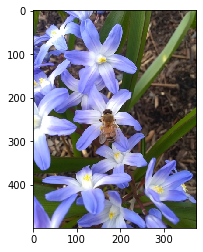

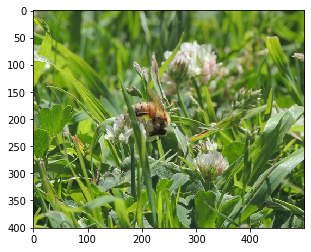

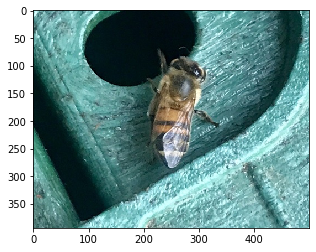

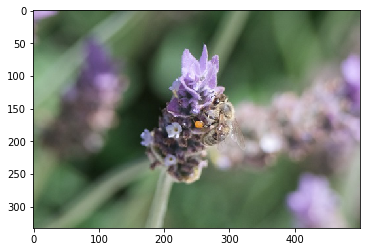

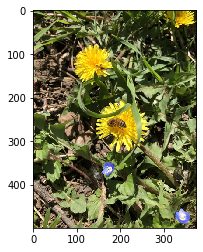

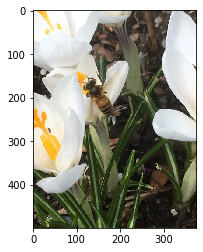

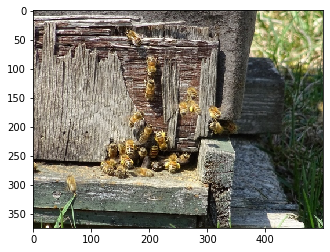

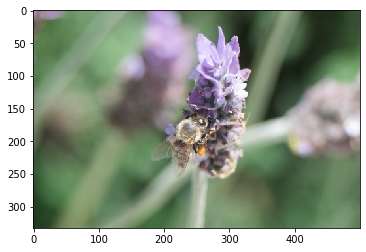

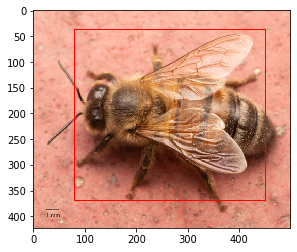

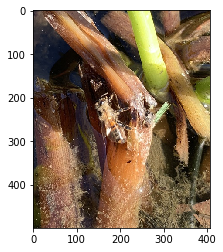

In [13]:
import boto3
import matplotlib.pyplot as plt
client = boto3.client('sagemaker')
import jsonlines
import json

endpoint_name='object-detection-2021-02-10-11-16-12-993-ep-2021-02'

runtime_client = boto3.client('sagemaker-runtime')

# Call SageMaker endpoint to obtain predictions
def get_predictions_for_img(runtime_client, endpoint_name, img_path):
    with open(img_path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)

    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                       ContentType='application/x-image', 
                                       Body=payload)

    result = response['Body'].read()
    result = json.loads(result)
    return result


# wait until the status has changed
client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
if status != 'InService':
    raise Exception('Endpoint creation failed.')

for test_image in test_images:
    result = get_predictions_for_img(runtime_client, endpoint_name, test_image)
    confidence_threshold = .5
    best_n = 1
    # display the best n predictions with confidence > confidence_threshold
    predictions = [prediction for prediction in result['prediction'] if prediction[1] > confidence_threshold]
    predictions.sort(reverse=True, key = lambda x: x[1])
    bboxes = [prediction_to_bbox_data(test_image, prediction) for prediction in predictions[:best_n]]
    show_annotated_image(test_image, bboxes)